In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import specialized plotting function for time series visualization
from utilsforecast.plotting import plot_series
# Import evaluation utilities for forecast accuracy assessment
from utilsforecast.evaluation import evaluate
# Import all loss functions (MAE, RMSE, etc.) for model evaluation
from utilsforecast.losses import *

import warnings
# Suppress all warning messages to keep output clean
warnings.filterwarnings("ignore")

# Initial setup

In [2]:
# parse_dates=["ds"] automatically converts the "ds" column to datetime format
df = pd.read_csv("daily_sales_french_bakery.csv", parse_dates=["ds"])
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [3]:
df.describe()

,ds,y,unit_price
count,57046,57046.000000,57046.000000
mean,2021-11-18 13:24:30.770956544,9.792814,3.631011
min,2021-01-02 00:00:00,0.000000,0.000000
25%,2021-06-25 00:00:00,0.000000,1.400000
50%,2021-11-17 00:00:00,0.900000,2.000000
75%,2022-04-17 00:00:00,8.000000,4.500000
max,2022-09-30 00:00:00,919.100000,60.000000
std,NaN,32.327068,3.909706


In [4]:
# Filter the dataset to keep only products with at least 28 days of data
# This ensures we have enough historical data for meaningful forecasting
# groupby('unique_id') groups by product, filter() applies the condition to each group
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [5]:
# Remove the "unit_price" column as it's not needed for forecasting for now
# axis=1 specifies we're dropping a column (not a row)
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


In [6]:
df.describe()

,ds,y
count,56904,56904.000000
mean,2021-11-18 15:23:18.397300480,9.796240
min,2021-01-02 00:00:00,0.000000
25%,2021-06-25 00:00:00,0.000000
50%,2021-11-17 00:00:00,0.900000
75%,2022-04-17 00:00:00,8.000000
max,2022-09-30 00:00:00,919.100000
std,NaN,32.357288


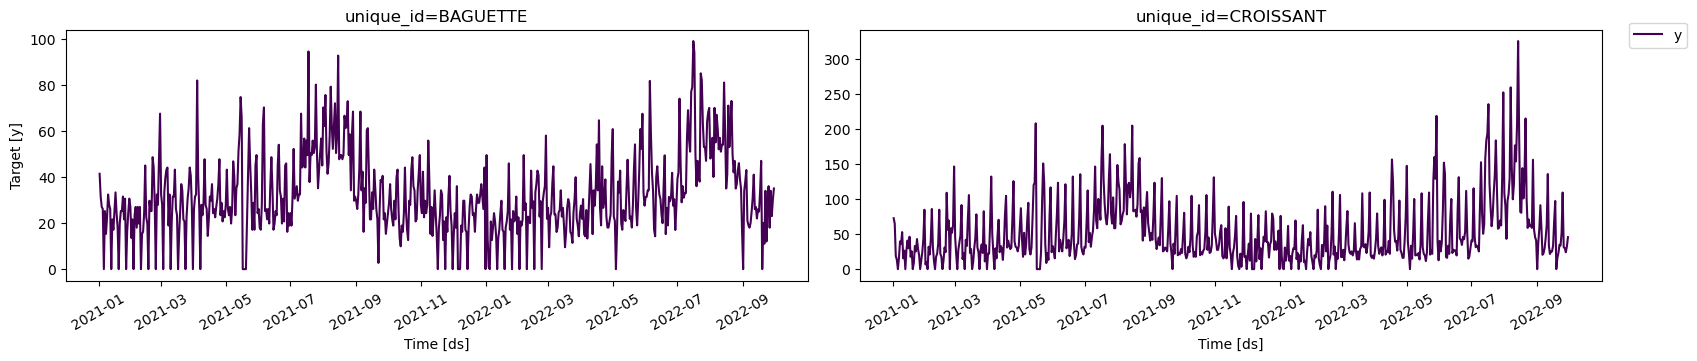

In [7]:
# Plot the complete time series for BAGUETTE and CROISSANT products
# palette="viridis" sets the color scheme for the plots
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], palette="viridis")

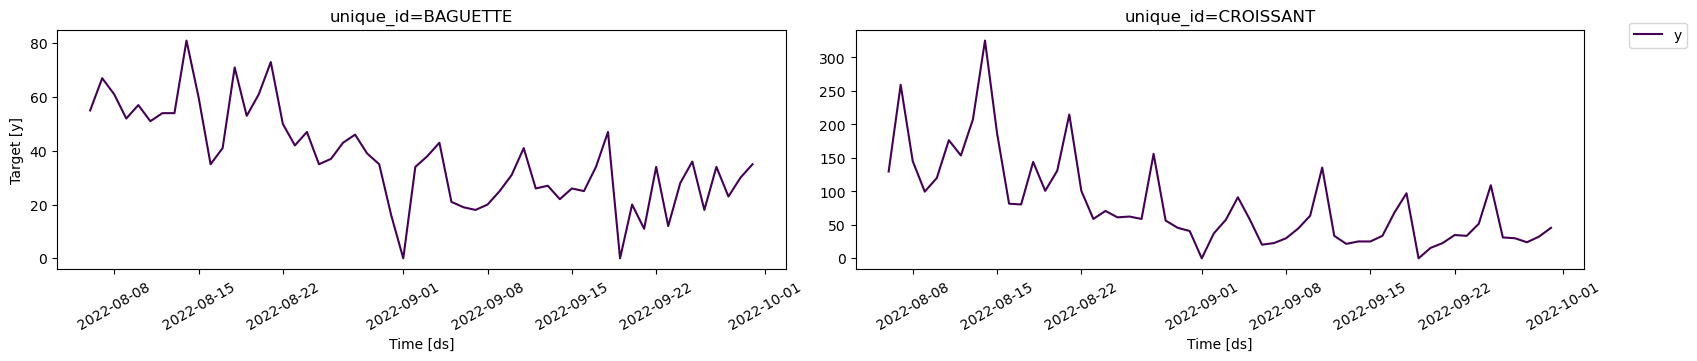

In [8]:
# Plot only the last 56 data points (most recent ~8 weeks) for better detail
# max_insample_length=56 limits the display to the last 56 observations
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

# Baseline models

In [9]:
# Import the main StatsForecast class for statistical forecasting
from statsforecast import StatsForecast
# Import various baseline forecasting models
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [10]:
# Set the forecast horizon to 7 days (1 week ahead)
horizon = 7

# Define a list of forecasting models to compare:
models = [
    # Naive: Uses the last observed value as the forecast
    Naive(),
    
    # HistoricAverage: Uses the average of all historical values
    HistoricAverage(),
    
    # WindowAverage: Uses the average of the last 7 observations (1 week)
    WindowAverage(window_size=7),
    
    # SeasonalNaive: Uses the value from the same day last week (7 days ago)
    # season_length=7 assumes weekly seasonality
    SeasonalNaive(season_length=7)
]

# Create a StatsForecast object with our models
# freq="D" specifies daily frequency
sf = StatsForecast(models=models, freq="D")
# StatsForecast expects the DataFrame to have exactly these column names:
# "ds" - the date/timestamp column
# "y" - the target values (what you want to forecast)
# "unique_id" - identifier for different time series (optional for single series)
sf.fit(df=df)
# Generate forecasts for the next 7 days
preds = sf.predict(h=horizon)

In [11]:
preds

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0
...,...,...,...,...,...,...
842,VIK BREAD,2022-10-03,32.4,14.566091,12.342857,0.0
843,VIK BREAD,2022-10-04,32.4,14.566091,12.342857,0.0
844,VIK BREAD,2022-10-05,32.4,14.566091,12.342857,0.0
845,VIK BREAD,2022-10-06,32.4,14.566091,12.342857,0.0


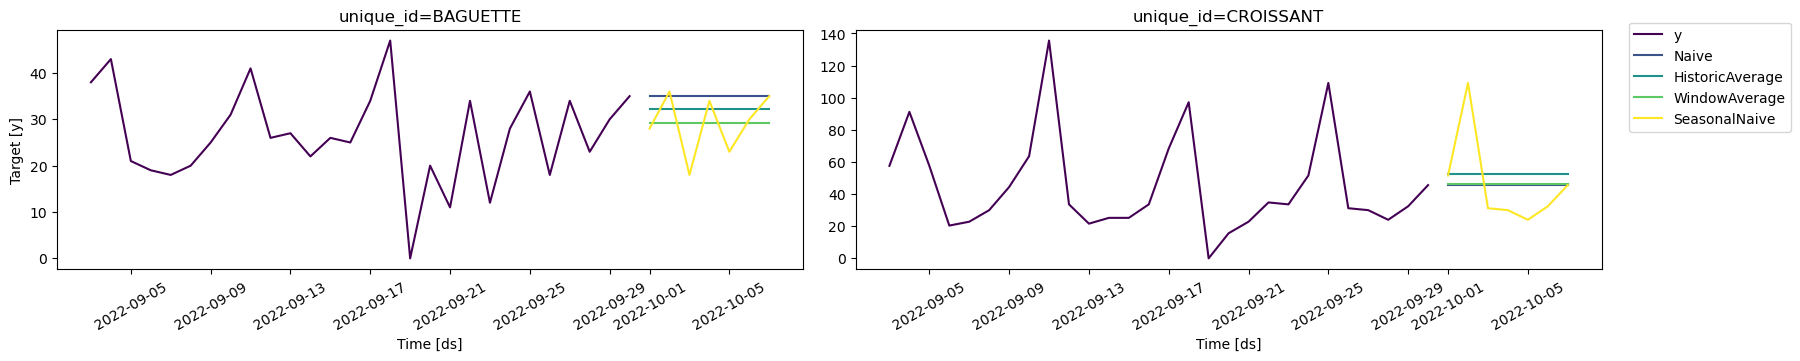

In [12]:
# Visualize the historical data and forecasts
# max_insample_length=28 shows only the last 28 days of historical data
# This provides a clearer view of recent trends and the forecasts
plot_series(
    df=df,                    # Historical data
    forecasts_df=preds,       # Forecast predictions
    ids=["BAGUETTE", "CROISSANT"],  # Products to display
    max_insample_length=28,   # Show last 28 days of history
    palette="viridis"         # Color scheme
)

# Evaluate baseline models

In [13]:
# Create test set: last 7 days of data for each product
# groupby("unique_id").tail(7) gets the last 7 rows for each unique product
test = df.groupby("unique_id").tail(7)

# Create training set: all data except the test set
# drop(test.index) removes test data rows, reset_index(drop=True) renumbers the rows
train = df.drop(test.index).reset_index(drop=True)

In [14]:
# Fit models using only the training data (excludes last 7 days)
sf.fit(df=train)

# Generate forecasts for the 7-day horizon
preds = sf.predict(h=horizon)

# Merge actual test values with predictions for comparison
# 'left' join keeps all test data, matches on date ('ds') and product ('unique_id')
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [15]:
eval_df

,unique_id,ds,y,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-22,0.0,0.0,9.577465,1.428571,10.0
1,12 MACARON,2022-09-23,0.0,0.0,9.577465,1.428571,0.0
2,12 MACARON,2022-09-24,10.0,0.0,9.577465,1.428571,0.0
3,12 MACARON,2022-09-25,0.0,0.0,9.577465,1.428571,0.0
4,12 MACARON,2022-09-26,0.0,0.0,9.577465,1.428571,0.0
...,...,...,...,...,...,...,...
842,VIK BREAD,2022-09-26,0.0,24.3,14.590794,11.957143,0.0
843,VIK BREAD,2022-09-27,0.0,24.3,14.590794,11.957143,0.0
844,VIK BREAD,2022-09-28,0.0,24.3,14.590794,11.957143,0.0
845,VIK BREAD,2022-09-29,0.0,24.3,14.590794,11.957143,0.0


In [16]:
# Calculate evaluation metrics (Mean Absolute Error) for each model
# mae is imported from utilsforecast.losses
evaluation = evaluate(
    eval_df,           # DataFrame with actual and predicted values
    metrics=[mae],     # List of metrics to calculate
)

# Display the first few rows of evaluation results
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [17]:
# Aggregate results by averaging across all products
# Drop 'unique_id' column, group by metric type, calculate mean, reset index
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


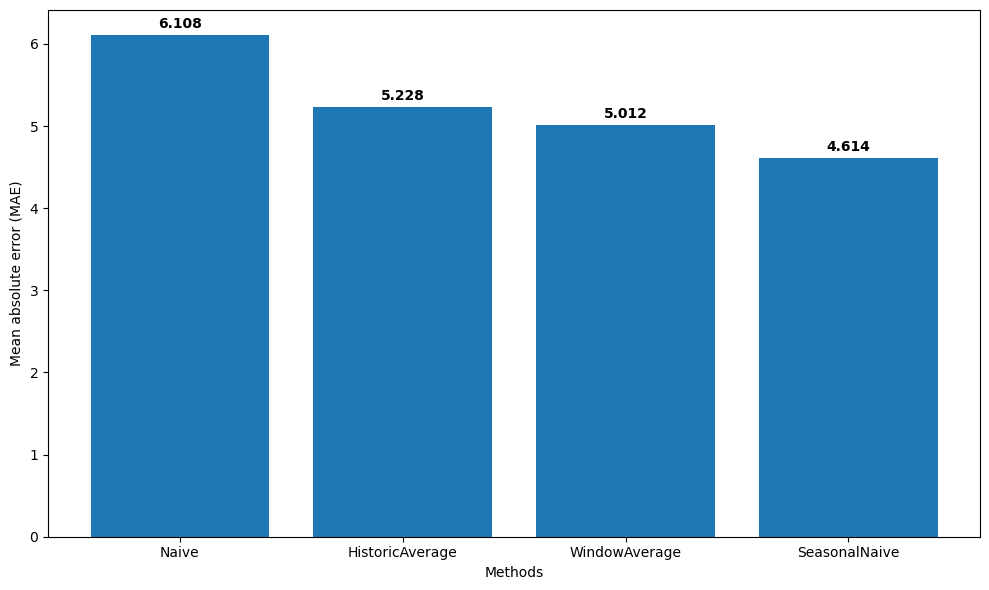

In [18]:
# Extract method names (column names except 'metric')
# tolist() converts pandas column names to a Python list
methods = evaluation.columns[1:].tolist()

# Extract MAE values for each method (first row, columns 1 onwards)
# iloc[0, 1:] gets first row, all columns except the first
values = evaluation.iloc[0, 1:].tolist()

# Create a bar chart to compare model performance
plt.figure(figsize=(10, 6))          # Set figure size to 10x6 inches
bars = plt.bar(methods, values)      # Create bar chart with methods and their MAE values

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    # Get bar center position (x-coordinate)
    x_pos = bar.get_x() + bar.get_width()/2
    # Get bar height (y-coordinate)  
    y_pos = bar.get_height() + 0.05
    # Add text label with MAE value (3 decimal places)
    plt.text(x_pos, y_pos, f'{value:.3f}', 
             ha='center',           # Horizontal alignment: center
             va='bottom',           # Vertical alignment: bottom
             fontweight='bold')     # Bold font

# Set axis labels
plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# AutoARIMA

In [19]:
# Import AutoARIMA model for automatic ARIMA parameter selection
# p = number of past values to use (AR order)
# d = how many times to difference the data (I order)
# q = number of past errors to use (MA order)
from statsforecast.models import AutoARIMA

In [20]:
# Select only two specific products for focused analysis
# This reduces computational time for ARIMA model fitting
unique_ids = ["BAGUETTE", "CROISSANT"]

# Filter training data to include only the selected products
# isin() checks if unique_id values are in the specified list
small_train = train[train["unique_id"].isin(unique_ids)]

# Filter test data to include only the selected products
small_test = test[test["unique_id"].isin(unique_ids)]

# Define ARIMA model variants:
models = [
    # Non-seasonal ARIMA: automatically selects best (p,d,q) parameters
    # seasonal=False disables seasonal components
    # alias="ARIMA" gives a custom name for easier identification
    AutoARIMA(seasonal=False, alias="ARIMA"),
    
    # Seasonal ARIMA: includes weekly seasonality
    # season_length=7 specifies 7-day seasonal cycle (weekly pattern)
    # alias="SARIMA" stands for Seasonal ARIMA
    AutoARIMA(season_length=7, alias="SARIMA")
]

# Create new StatsForecast instance with ARIMA models
# freq="D" specifies daily frequency
sf = StatsForecast(models=models, freq="D")

# Fit ARIMA models on the reduced training dataset
# ARIMA fitting is computationally intensive, hence the smaller dataset
sf.fit(df=small_train)

# Generate 7-day forecasts using the fitted ARIMA models
arima_preds = sf.predict(h=horizon)

# Merge ARIMA predictions with the existing evaluation dataframe
# 'inner' join keeps only matching records (BAGUETTE and CROISSANT)
# This combines ARIMA forecasts with the baseline model results
arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])

# Evaluate ARIMA model performance using Mean Absolute Error
arima_eval = evaluate(
    arima_eval_df,     # DataFrame with actual values and ARIMA predictions
    metrics=[mae],     # Calculate MAE for model comparison
)

# Display the ARIMA evaluation results
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565396,10.359143,17.485714,22.618934,18.244898,12.857143


In [21]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


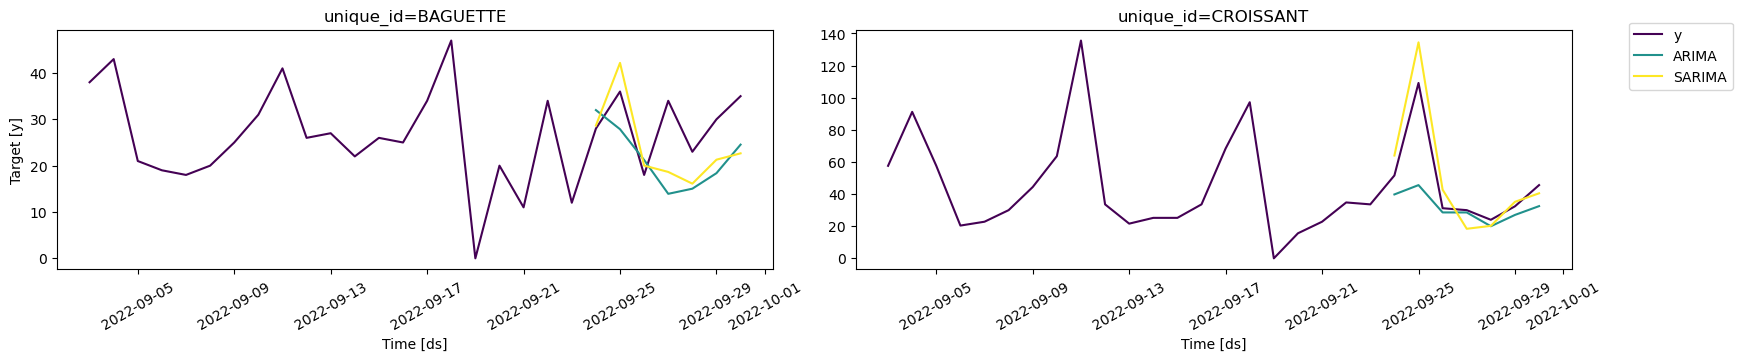

In [22]:
# Visualize the ARIMA forecasts alongside historical data
plot_series(
    df=df,                          # Full historical dataset
    forecasts_df=arima_preds,       # ARIMA model predictions
    ids=["BAGUETTE", "CROISSANT"],  # Focus on the two products
    max_insample_length=28,         # Show last 28 days of history
    palette="viridis"               # Color scheme
)

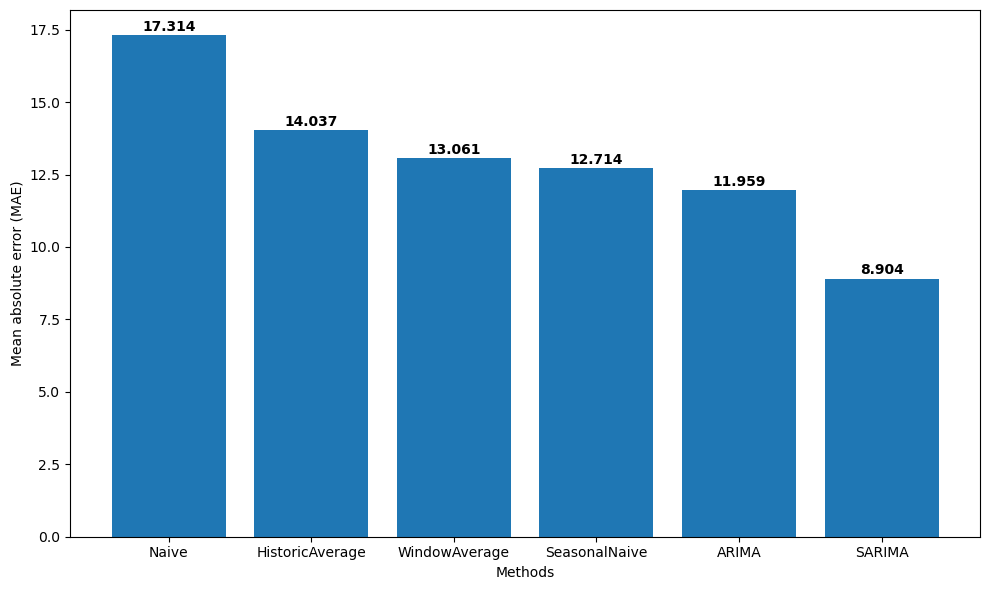

In [23]:
# Extract method names from the ARIMA evaluation results
# columns[1:] excludes the first column (metric name)
methods = arima_eval.columns[1:].tolist()

# Extract MAE values for each ARIMA method
# iloc[0, 1:] gets first row, all columns except the metric column
values = arima_eval.iloc[0, 1:].tolist()

# Create tuples of (method, MAE_value) and sort by MAE in descending order
# key=lambda x: x[1] sorts by the second element (MAE value)
# reverse=True sorts from highest to lowest MAE (worst to best performance)
sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)

# Unpack the sorted data back into separate lists
# zip(*sorted_data) transposes the list of tuples back to two separate lists
methods_sorted, values_sorted = zip(*sorted_data)

# Create a bar chart with methods sorted by performance (worst to best, left to right)
plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

# Add MAE value labels on top of each bar
for bar, value in zip(bars, values_sorted):
    # Calculate center position of each bar
    x_pos = bar.get_x() + bar.get_width()/2
    y_pos = bar.get_height() + 0.05
    # Display MAE value with 3 decimal places
    plt.text(x_pos, y_pos, f'{value:.3f}', 
             ha='center',           # Center horizontally
             va='bottom',           # Align to bottom of text
             fontweight='bold')     # Bold font for readability

# Set axis labels
plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Cross-validation

In [24]:
# Filter the full dataset to include only the two selected products
# This creates a smaller dataset for more focused cross-validation analysis
small_df = df[df["unique_id"].isin(unique_ids)]

# Define models for comprehensive comparison:
models = [
    # SeasonalNaive: Simple baseline that uses the value from 7 days ago
    # Good benchmark to compare against more sophisticated methods
    SeasonalNaive(season_length=7),
    
    # Non-seasonal ARIMA: Captures trends and autocorrelation
    AutoARIMA(seasonal=False, alias="ARIMA"),
    
    # Seasonal ARIMA: Additionally captures weekly patterns
    AutoARIMA(season_length=7, alias="SARIMA")
]

# Create StatsForecast instance with the selected models
sf = StatsForecast(models=models, freq="D")

# Perform time series cross-validation
# This is much more robust than single train-test split
cv_df = sf.cross_validation(
    h=horizon,        # Forecast horizon: 7 days ahead
    df=small_df,      # Dataset to use for cross-validation
    n_windows=8,      # Number of validation windows to test
    step_size=horizon, # Move forward by 7 days between each window
    refit=True        # Refit models for each window (more realistic)
)

# Display the first few rows of cross-validation results
# This shows actual values (y) vs predictions for each model and time window
cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355199,71.584714
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337984,78.458884
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195008,57.001733
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649015,49.401146
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785877,49.725280


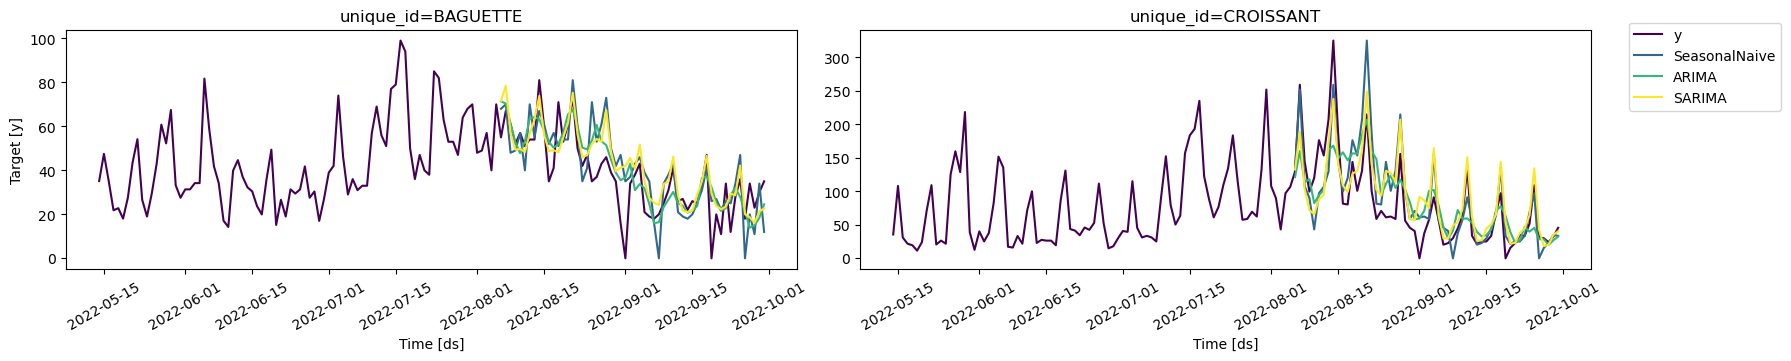

In [25]:
# Visualize cross-validation forecasts across multiple time periods
plot_series(
    df=small_df,                                    # Historical data
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1), # Remove actual values and cutoff columns
    ids=["BAGUETTE", "CROISSANT"],                  # Products to display
    max_insample_length=140,                        # Show last ~20 weeks of data
    palette="viridis"                               # Color scheme
)

In [26]:
# Calculate evaluation metrics across all cross-validation windows
# Remove 'cutoff' column as it's not needed for evaluation
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),  # Cross-validation results without cutoff dates
    metrics=[mae],                   # Calculate Mean Absolute Error
)

# Aggregate results across products and time windows
# This gives us the average performance of each model across all test periods
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

# Display the aggregated cross-validation evaluation results
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.747463,19.281295


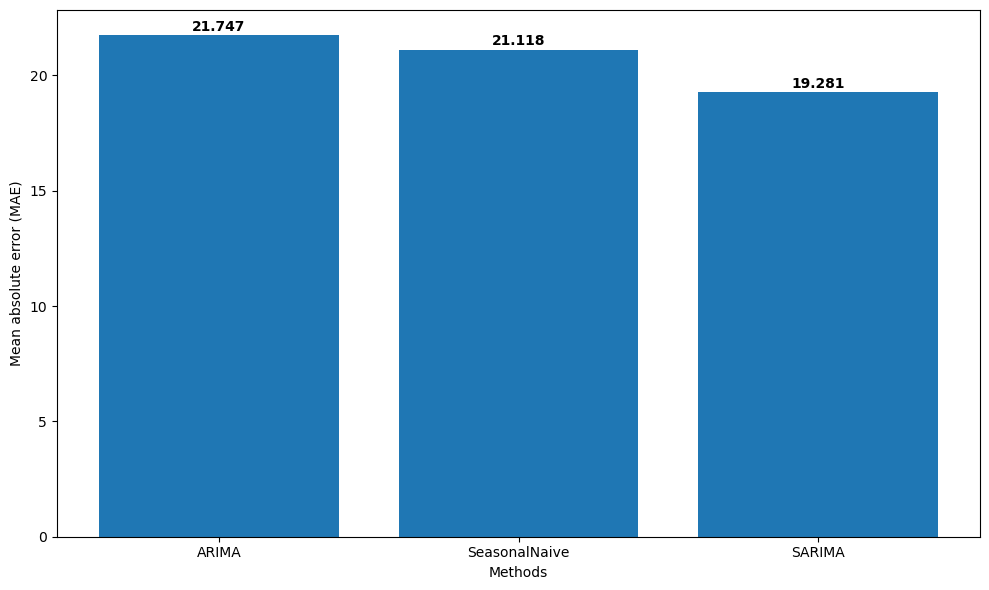

In [27]:
# Extract method names from the cross-validation evaluation
methods = cv_eval.columns[1:].tolist()

# Extract MAE values for each method
values = cv_eval.iloc[0, 1:].tolist()

# Sort methods by performance (worst to best)
# This helps identify which model performs best on average
sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

# Create bar chart showing cross-validation performance
plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

# Add performance labels on each bar
for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

# Forecasting with exogenous features

In [31]:
# Load the daily sales data from French bakery with date parsing
df = pd.read_csv("daily_sales_french_bakery.csv", parse_dates=["ds"])

# Filter out time series with less than 28 data points to ensure sufficient history
# This removes series that are too short for meaningful analysis
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)

# Display first few rows to understand the data structure
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


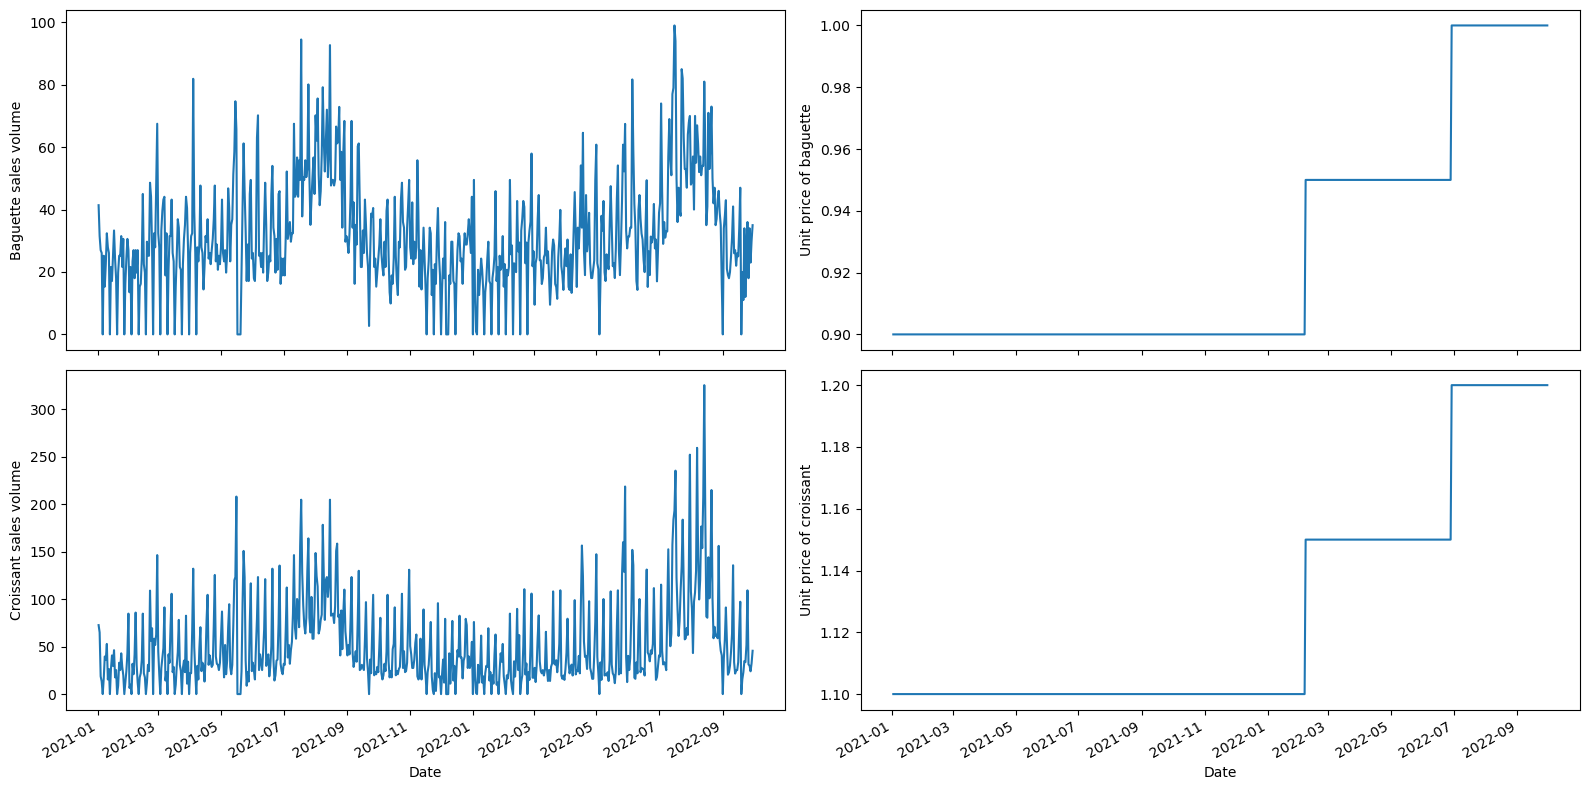

In [32]:
# Extract data for specific products to create visualization plots
baguette_plot_df = df[df["unique_id"] == "BAGUETTE"]  # Filter for baguette sales data
croissant_plot_df = df[df["unique_id"] == "CROISSANT"]  # Filter for croissant sales data

# Create a 2x2 subplot layout for comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

# Plot baguette sales volume over time (top-left subplot)
ax1.plot(baguette_plot_df["ds"], baguette_plot_df["y"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Baguette sales volume")

# Plot baguette unit price over time (top-right subplot)
# This is the exogenous variable that might influence sales
ax2.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Unit price of baguette")

# Plot croissant sales volume over time (bottom-left subplot)
ax3.plot(croissant_plot_df["ds"], croissant_plot_df["y"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Croissant sales volume")

# Plot croissant unit price over time (bottom-right subplot)
# Another exogenous variable for the second product
ax4.plot(croissant_plot_df["ds"], croissant_plot_df["unit_price"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit price of croissant")

# Format x-axis dates for better readability
fig.autofmt_xdate()
# Adjust subplot spacing to prevent overlap
plt.tight_layout()

In [33]:
# Define which products to analyze (limiting scope for demonstration)
unique_ids = ["BAGUETTE", "CROISSANT"]
# Filter dataset to only include selected products
small_df = df[df["unique_id"].isin(unique_ids)]

# Create test set: take last 7 days for each product
test = small_df.groupby("unique_id").tail(7)
# Create training set: all data except test set, reset index for clean indexing
train = small_df.drop(test.index).reset_index(drop=True)

# Prepare future exogenous variables for prediction
# Remove target variable 'y' but keep exogenous features like 'unit_price'
futr_exog_df = test.drop(["y"], axis=1)
futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [34]:
# Model 1: SARIMA with exogenous variables
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")  # Weekly seasonality, include exogenous vars
]

# Initialize StatsForecast with daily frequency
sf = StatsForecast(models=models, freq="D")
# Fit model on training data (includes exogenous variables automatically)
sf.fit(df=train)
# Generate predictions using future exogenous variables
arima_exog_preds = sf.predict(h=7, X_df=futr_exog_df)

# Model 2: SARIMA without exogenous variables (for comparison)
models = [
    AutoARIMA(season_length=7, alias="SARIMA")  # Same model but without exogenous features
]

sf = StatsForecast(models=models, freq="D")
# Fit on training data without exogenous variables (drop unit_price column)
sf.fit(df=train.drop(["unit_price"], axis=1))
# Generate predictions without using exogenous information
arima_preds = sf.predict(h=horizon)

In [35]:
# Combine actual test values with both sets of predictions for comparison
test_df = test.merge(arima_exog_preds, on=["unique_id", "ds"], how="left")\
              .merge(arima_preds, on=["unique_id", "ds"], how="left")
test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898845,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513191,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423883,20.013654
3,BAGUETTE,2022-09-27,34.0,1.0,19.066170,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468806,16.114925
5,BAGUETTE,2022-09-29,30.0,1.0,21.656649,21.288017
6,BAGUETTE,2022-09-30,35.0,1.0,23.101138,22.660124
7,CROISSANT,2022-09-24,51.6,1.2,64.425428,64.011002
8,CROISSANT,2022-09-25,109.2,1.2,135.125003,134.488202
9,CROISSANT,2022-09-26,31.2,1.2,43.527280,42.735407


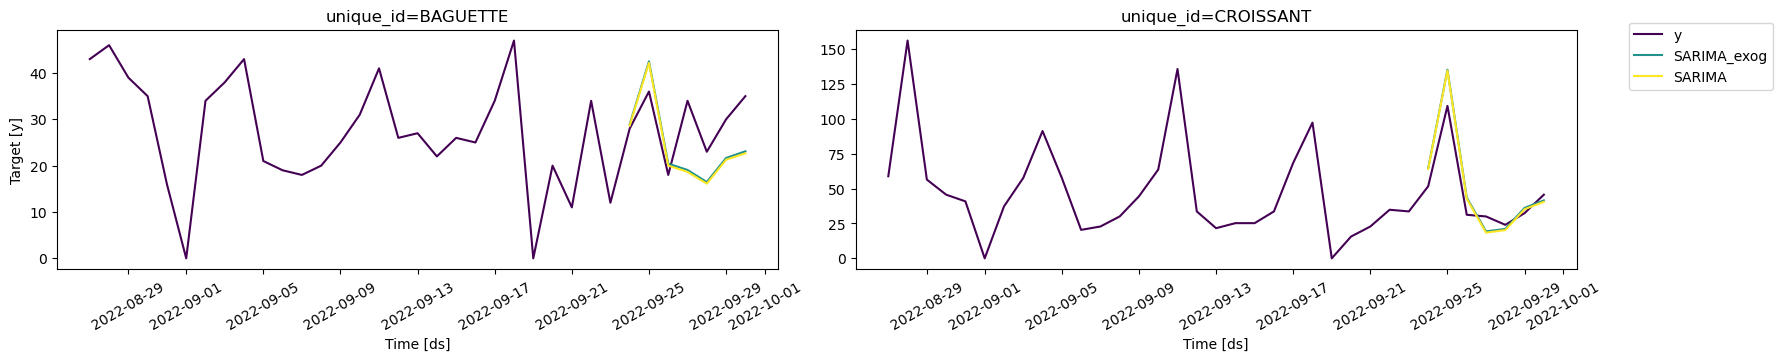

In [36]:
# Visualize the forecasting results
plot_series(
    df=train,                          # Historical training data
    forecasts_df=test_df,             # Test data with predictions
    ids=["BAGUETTE", "CROISSANT"],    # Products to plot
    max_insample_length=28,           # Show last 28 days of training data
    models=["SARIMA_exog", "SARIMA"], # Compare both model types
    palette="viridis"                 # Color scheme for visualization
)

In [37]:
# Perform cross-validation to get robust performance metrics
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
# Cross-validation with multiple time windows
cv_exog_df = sf.cross_validation(
    h=horizon,        # Forecast horizon (7 days)
    df=small_df,      # Full dataset including exogenous variables
    n_windows=8,      # Number of validation windows to test
    step_size=7,      # Step between validation windows (weekly steps)
    refit=True        # Refit model for each window (more accurate but slower)
)
cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511241
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.457685
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062298
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525368
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485300


In [38]:
# Evaluate cross-validation results using Mean Absolute Error
cv_exog_eval = evaluate(
    cv_exog_df.drop(["cutoff"], axis=1),  # Remove cutoff column, keep predictions
    metrics=[mae],                         # Use Mean Absolute Error as metric
)

# Aggregate results: average MAE across all products and windows
cv_exog_eval = cv_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.210822


# Creating features from timestamps

In [39]:
# Import required modules for feature engineering
from functools import partial  # Allows pre-configuring function parameters
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [40]:
# Define feature engineering functions with pre-configured parameters
features = [
    # Fourier features: Capture cyclical patterns using trigonometric functions
    # season_length=7: Weekly seasonality (7 days)
    # k=2: Creates 4 features (2 sine + 2 cosine waves at different frequencies)
    partial(fourier, season_length=7, k=2),
    
    # Time-based features: Extract calendar information from timestamps
    # Creates binary/categorical features for day of week, week of year, month
    partial(time_features, features=["day", "week", "month"])
]

# Apply feature engineering pipeline to create training and future exogenous datasets
small_exog_df, futr_exog_df = pipeline(
    df=small_df,           # Input dataframe with time series data
    features=features,     # List of feature engineering functions to apply
    freq="D",             # Daily frequency
    h=horizon             # Forecast horizon (creates future features for this many periods)
)

In [41]:
# Display first few rows to see the newly created timestamp-based features
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [42]:
# Show future exogenous features (for forecasting period)
# These contain the engineered features for the forecast horizon
futr_exog_df

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10
5,BAGUETTE,2022-10-06,-0.781828,-0.974931,0.623495,-0.222509,6,40,10
6,BAGUETTE,2022-10-07,-0.000009,-0.000017,1.000000,1.000000,7,40,10
7,CROISSANT,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
8,CROISSANT,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
9,CROISSANT,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10


In [43]:
# Create model using timestamp-based exogenous features
models = [
    AutoARIMA(season_length=7, alias="SARIMA_time_exog")  # SARIMA with time-based features
]

# Initialize forecasting framework
sf = StatsForecast(models=models, freq="D")

# Perform cross-validation with timestamp features
cv_time_exog_df = sf.cross_validation(
    h=horizon,                # Forecast horizon (7 days)
    df=small_exog_df,        # Dataset with engineered timestamp features
    n_windows=8,             # Number of cross-validation windows
    step_size=horizon,       # Step between windows (non-overlapping: 7 days)
    refit=True              # Refit model parameters for each window
)

# Evaluate cross-validation results
cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(["cutoff"], axis=1),  # Remove cutoff dates, keep predictions
    metrics=[mae],                              # Use Mean Absolute Error
)

# Aggregate results: average MAE across products and cross-validation windows
cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.668347


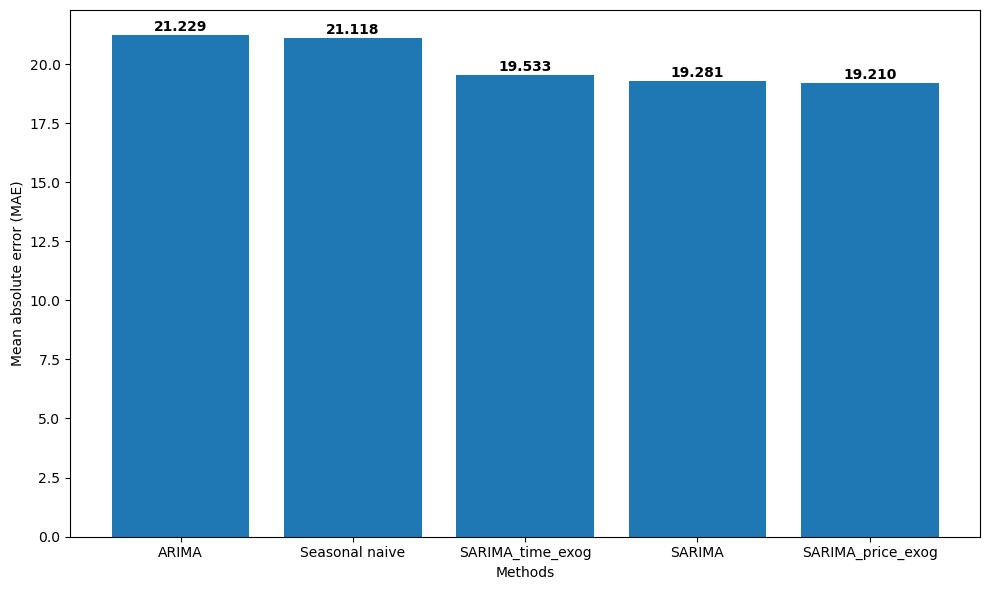

In [44]:
# Define all forecasting methods tested and their MAE performance
methods = ["ARIMA", "Seasonal naive", "SARIMA", "SARIMA_price_exog", "SARIMA_time_exog"] 
values = [21.229, 21.118, 19.281, 19.210, 19.533]  # Corresponding MAE values

# Sort methods by performance (highest MAE to lowest for visual impact)
sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

# Create performance comparison bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

# Add MAE values as text labels on top of each bar
for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2,  # Center horizontally on bar
             bar.get_height() + 0.05,           # Slightly above bar top
             f'{value:.3f}',                    # Format to 3 decimal places
             ha='center',                       # Horizontal alignment: center
             va='bottom',                       # Vertical alignment: bottom
             fontweight='bold')                 # Make text bold

# Customize plot appearance
plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()  # Adjust spacing to prevent label cutoff

plt.show()

# Prediction Intervals

In [45]:
# Select specific products for focused analysis
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]

# Create test set: last 7 days for each product
test = small_df.groupby("unique_id").tail(7)
# Create training set: all data except test set, reset index for clean indexing
train = small_df.drop(test.index).reset_index(drop=True)

# Display training data structure
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [46]:
# Define model for prediction intervals
models = [
    AutoARIMA(season_length=7)  # SARIMA model with weekly seasonality
]

# Initialize StatsForecast framework
sf = StatsForecast(models=models, freq="D")
# Fit model on training data
sf.fit(df=train)

# Generate predictions WITH prediction intervals
prob_preds = sf.predict(
    h=horizon,                          # Forecast horizon (7 days)
    X_df=test.drop(["y"], axis=1),     # Future exogenous variables (if any)
    level=[80]                         # Confidence level: 80% prediction intervals
)
# level=[80] creates:
# - AutoARIMA-lo-80: Lower bound (10th percentile)
# - AutoARIMA-hi-80: Upper bound (90th percentile)
# - AutoARIMA: Point forecast (50th percentile/median)

In [47]:
# Merge actual test values with probabilistic predictions
test_df = test.merge(prob_preds, on=["unique_id", "ds"], how="left")

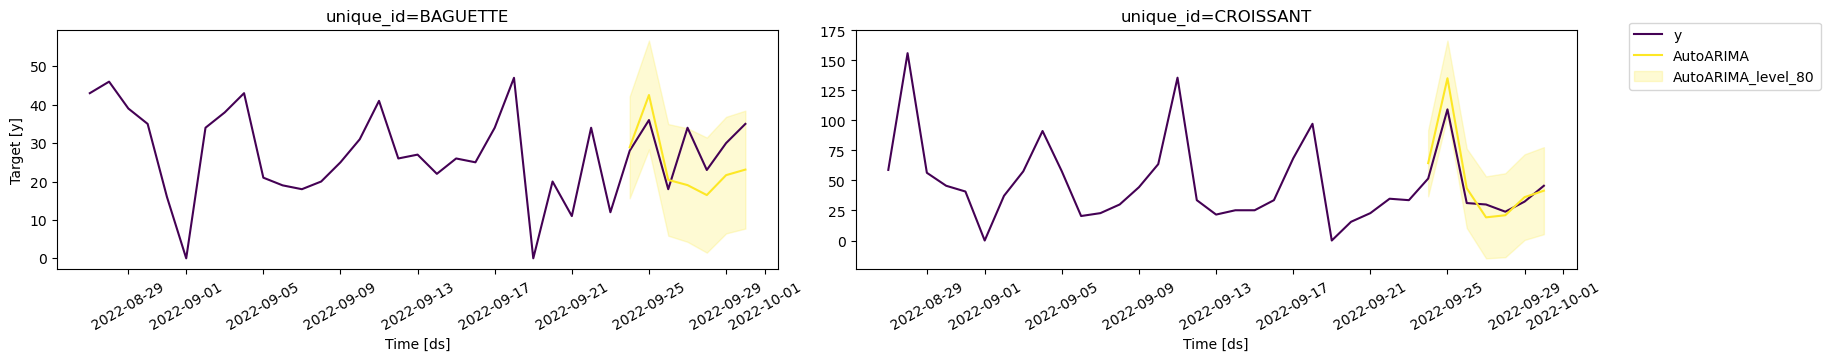

In [49]:
# Visualize predictions with uncertainty bands
plot_series(
    df=train,                          # Historical training data
    forecasts_df=test_df,             # Test data with predictions and intervals
    ids=["BAGUETTE", "CROISSANT"],    # Products to visualize
    max_insample_length=28,           # Show last 28 days of training data for context
    models=["AutoARIMA"],             # Model to plot
    level=[80],                       # Show 80% prediction intervals as shaded area
    palette="viridis"                 # Color scheme
)

In [50]:
# Same model configuration
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")

# Cross-validation WITH prediction intervals
cv_prob_df = sf.cross_validation(
    h=horizon,              # 7-day forecast horizon
    df=small_df,           # Full dataset
    n_windows=8,           # 8 different validation windows
    step_size=7,           # Weekly steps between windows
    refit=True,            # Refit model parameters for each window
    level=[80],            # Generate 80% prediction intervals for each forecast
)

# This creates multiple forecasts with intervals across different time periods
# Each row represents a forecast made at a different "cutoff" date

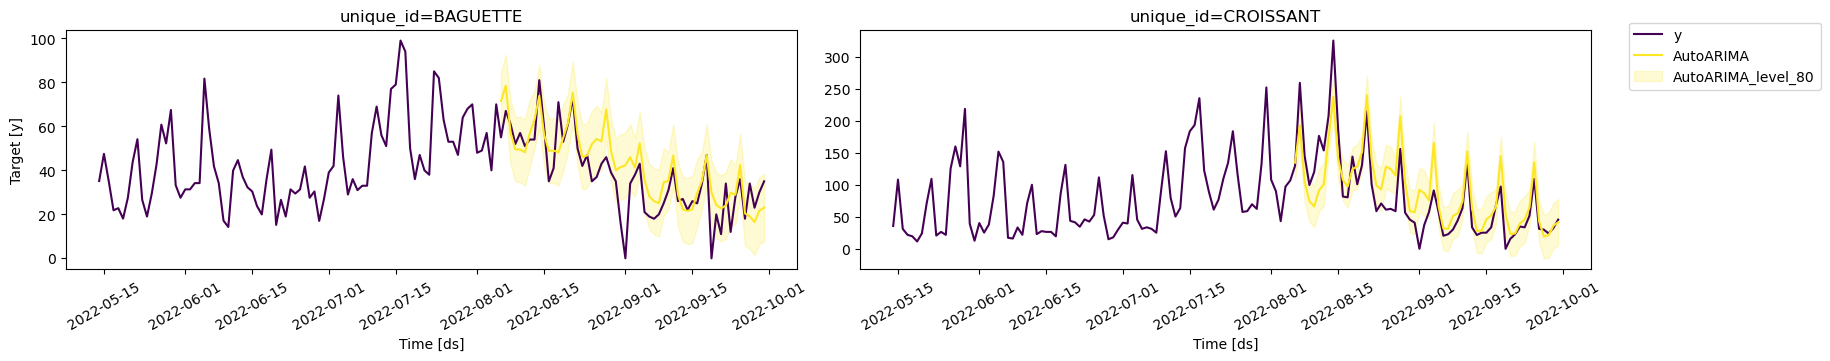

In [51]:
# Visualize cross-validation results with prediction intervals
plot_series(
    df=small_df,                                           # Full historical data
    forecasts_df=cv_prob_df.drop(["y", "cutoff"], axis=1), # CV predictions (remove actuals & cutoff dates)
    ids=["BAGUETTE", "CROISSANT"],                         # Products to plot
    models=["AutoARIMA"],                                  # Model to visualize
    max_insample_length=140,                               # Show more historical context (20 weeks)
    level=[80],                                            # Display 80% confidence bands
    palette="viridis"                                      # Color palette
)

# Evaluation metrics

In [56]:
# Define multiple models for comprehensive comparison
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog"),  # Advanced SARIMA model
    SeasonalNaive(season_length=7)                    # Simple seasonal baseline
]

# Initialize forecasting framework
sf = StatsForecast(models=models, freq="D")

# Perform cross-validation with prediction intervals
final_cv_df = sf.cross_validation(
    h=horizon,          # 7-day forecast horizon
    df=small_df,        # Dataset with both products
    n_windows=8,        # 8 cross-validation windows
    step_size=7,        # Weekly steps between windows
    refit=True,         # Refit models for each window (more accurate)
    level=[80],         # Generate 80% prediction intervals
)

# Display cross-validation results structure
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511241,58.278922,84.743560,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.457685,64.353734,92.561637,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062298,42.621727,71.502869,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525368,34.846782,64.203954,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485300,34.606419,64.364182,57.0,39.158042,74.841958


In [60]:
# Create test set for evaluation metrics that require train data
# Take last 56 days (7 days × 8 windows) as comprehensive test period
temp_test = small_df.groupby("unique_id").tail(7*8)
# Remaining data becomes training set for metric calculations
temp_train = small_df.drop(temp_test.index).reset_index(drop=True)

In [62]:
# Define multiple evaluation metrics for thorough assessment
models = ["SARIMA_exog", "SeasonalNaive"]
metrics = [
    mae,                               # Mean Absolute Error - average |actual - predicted|
    mse,                               # Mean Squared Error - average (actual - predicted)²
    rmse,                              # Root Mean Squared Error - √MSE (same units as target)
    mape,                              # Mean Absolute Percentage Error - average |actual - predicted|/actual * 100
    smape,                             # Symmetric MAPE - handles zero values better
    partial(mase, seasonality=7),      # Mean Absolute Scaled Error - relative to seasonal naive
    scaled_crps                        # Scaled Continuous Ranked Probability Score - for probabilistic forecasts
]

# Compute all metrics for all models
final_eval = evaluate(
    final_cv_df.drop(["ds", "cutoff"], axis=1),  # Remove date columns, keep predictions
    metrics=metrics,                              # Apply all defined metrics
    models=models,                               # Evaluate specified models
    train_df=temp_train,                        # Training data needed for scaled metrics (MASE)
    level=[80]                                  # Evaluate prediction intervals (for CRPS)
)

# Aggregate results: average across products and cross-validation windows
final_eval = final_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,19.210822,21.117857
1,mape,0.328607,0.376819
2,mase,1.181451,1.328592
3,mse,792.679634,970.417143
4,rmse,24.978103,27.875413
5,scaled_crps,0.153624,0.166451
6,smape,0.168235,0.211317


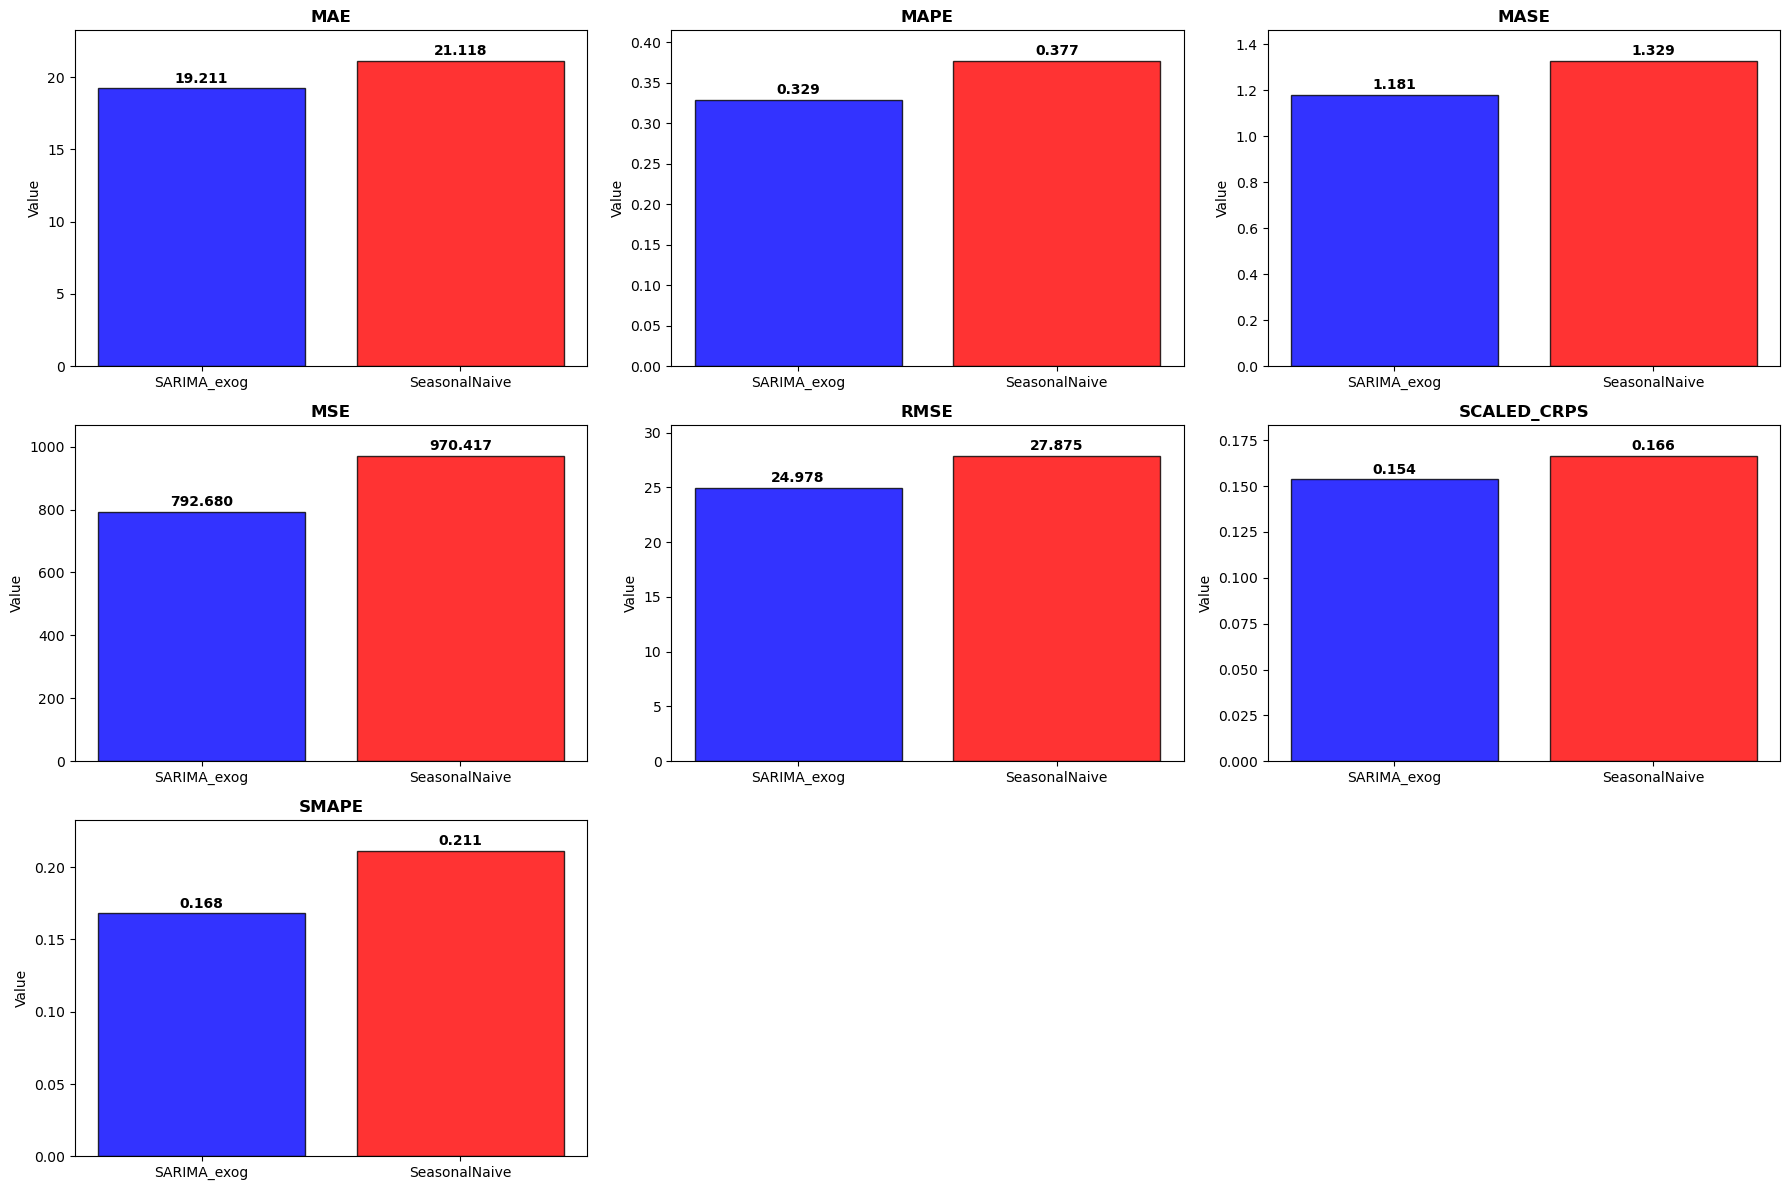

In [63]:
# Create 3x3 subplot grid for all metrics
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

# Define visualization parameters
models = ['SARIMA_exog', 'SeasonalNaive']
x_pos = [0, 1]                    # X-axis positions for bars
colors = ['blue', 'red']          # Colors for each model

# Create bar chart for each metric
for i, row in final_eval.iterrows():
    ax = axes_flat[i]  # Current subplot
    
    # Extract metric values for both models
    model_values = [row['SARIMA_exog'], row['SeasonalNaive']]
    
    # Create bar chart with custom styling
    bars = ax.bar(x_pos, model_values, 
                  color=colors,           # Model-specific colors
                  alpha=0.8,             # Semi-transparent
                  edgecolor='black',     # Black borders
                  linewidth=1)           # Border thickness
    
    # Add value labels on top of each bar
    for j, (bar, value) in enumerate(zip(bars, model_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.,  # Center horizontally
                height + height*0.01,              # Slightly above bar
                f'{value:.3f}',                     # Format to 3 decimal places
                ha='center', va='bottom',           # Text alignment
                fontweight='bold', fontsize=10)     # Text styling
    
    # Customize subplot appearance
    ax.set_title(row['metric'].upper(),           # Metric name as title (uppercase)
                fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)                         # Set x-axis tick positions
    ax.set_xticklabels(models, ha='center')      # Model names as x-labels
    ax.set_ylabel('Value')                       # Y-axis label
    
    # Set y-axis limits with some padding
    max_value = max(model_values)
    ax.set_ylim(0, max_value * 1.1)             # 10% padding above maximum

# Remove unused subplots (we have 7 metrics, 9 subplot positions)
fig.delaxes(axes_flat[7])      # Remove 8th subplot
axes_flat[8].set_visible(False) # Hide 9th subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()